# Modelagem e arquitetura CNN

## Modelo de canal único Raw RGB pré treinado InceptionV3 + IMAGENET (Top layers off)

### Conteúdo

- Ingestão
- Pré processamento
- Modelagem da rede
- Treinamento
- Teste
- Validação
- Resultados

### Importações e parâmetros

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import tensorflow as tf
#import tensorflow_datasets as tfds
#tfds.disable_progress_bar()

videos_table_path = 'manual_frame_classification.csv'
videos_table_path_validation = 'manual_frame_validation.csv'
max_positive_cases = 5000
max_validation_cases = 10000
preprocess_training_test = False
preprocess_validation = True

### Ingestão

In [2]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def process_path(file_path):
    img = tf.io.read_file(file_path, )
    img = decode_img(img)
    return img

def process_label(label):
    return label == 'POS'

def process_dataframe(dataframe):
    xs = []
    ys = []
    with tf.device('/cpu:0'):
        for i,row in dataframe.iterrows():
            path = row['path']
            label = row['violence']
            xs.append(process_path(path))
            ys.append(process_label(label))
        return tf.data.Dataset.from_tensor_slices((xs,ys))

In [3]:
#IMPORT
frames_df = pd.read_csv(videos_table_path, sep=';', index_col=0)
video_list = frames_df[frames_df['load'] == 'X']['video'].unique()

#SEGREGATE
msk = np.random.rand(len(video_list)) < 0.9
train_test_videos = video_list[msk]
validation_videos =  video_list[~msk]
train_test_df = frames_df.loc[frames_df['video'].isin(train_test_videos)]
validation_df = frames_df.loc[frames_df['video'].isin(validation_videos)]

neg_df = train_test_df[train_test_df['violence'] == 'NEG'][['path','violence']]
pos_df = train_test_df[train_test_df['violence'] == 'POS'][['path','violence']]
neg_len = len(neg_df)
pos_len = len(pos_df)

#SHUFFLE
neg_df = neg_df.sample(frac=1).reset_index(drop=True)
pos_df = pos_df.sample(frac=1).reset_index(drop=True)
validation_df = validation_df.sample(frac=1).reset_index(drop=True)

#RESIZE
train_test_size = min([len(pos_df),max_positive_cases])
train_size = int(0.7*train_test_size)
test_size = train_test_size - train_size

pos_train_df = pos_df.head(train_size)
pos_test_df = pos_df.tail(test_size)

neg_train_df = neg_df.head(train_size)
neg_test_df = neg_df.tail(int(test_size*(neg_len/pos_len)))
                          
#MERGE
merged_train_df = pd.concat([pos_train_df, neg_train_df], ignore_index=True)
merged_test_df = pd.concat([pos_test_df, neg_test_df], ignore_index=True)
train_length = len(merged_train_df)
test_length = len(merged_test_df)
validation_length = len(validation_df)

print('Train dataset cases :' + str(train_length))
print('Test dataset cases :' + str(test_length))
print('Validation dataset cases :' + str(validation_length))

c:\users\red\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Train dataset cases :7000
Test dataset cases :17895
Validation dataset cases :40650


### Pré processamento

### Observações

Dataset claramente tendencioso (biased), será necessário tratar o desbalanceamento na fase de préprocessamento a fim de manter uma RN bem treinada.

#### Tarefas
- Separação do dataset em:
    - Dataset de treinamento (70%)
    - Dataset de teste (30%)

    
OBS: Todos os datasets devem estar balanceados! Portanto a medida balizadora será o gargalo atual: número de casos positivos. 

In [4]:
if preprocess_validation:
    validation_df = pd.read_csv('validation_shuffled_df_inception.csv', sep=';')
    validation_length = len(validation_df)

#RESHUFLE
if preprocess_training_test:
    shuffled_train_df = merged_train_df.sample(frac=1).reset_index(drop=True)
    shuffled_test_df = merged_test_df.sample(frac=2*test_size/test_length).reset_index(drop=True)

if preprocess_validation:
    validation_shuffled_df = validation_df.sample(frac=min(1,max_validation_cases/validation_length)).reset_index(drop=True)
    validation_length = len(validation_shuffled_df)

#PROCESS
if preprocess_training_test:
    train_ds = process_dataframe(shuffled_train_df)
    test_ds = process_dataframe(shuffled_train_df)
if preprocess_validation:
    validation_ds = process_dataframe(validation_shuffled_df)

#print('Train DataFrame size: ' + str(int(train_length)))
#print('Test DataFrame size: ' + str(int(test_length*2*test_size/test_length)))
#print('Validation DataFrame size: ' + str(int(validation_length)))

### Clear unused data
frames_df = None
neg_df = None
pos_df = None
#merged_df = None
shuffled_df = None
complete_dataset = None

In [16]:
validation_df.to_csv('validation_shuffled_df_inception.csv', sep=';')

In [6]:
train_batches = train_ds.shuffle(100).batch(50)

### Ponto de execução para treinamento

Caso queira seguir com a criação do modelo executar os blocos a seguir

### Modelagem da CNN

In [7]:
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
base_model.trainable = False

x = tf.keras.layers.Flatten()(base_model.output)
#x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(base_model.input, x)

### Salvar modelo

In [8]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]) #

In [9]:
model.save('cnn_inceptionv3_pretrainned_raw_rgb_v1')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: cnn_inceptionv3_pretrainned_raw_rgb_v1\assets


### Carregar modelo

- OBS : Lembrar de ligar GPU

In [5]:
model = tf.keras.models.load_model('cnn_inceptionv3_pretrainned_raw_rgb_v1')

In [10]:
history = model.fit_generator(train_batches, epochs=100, use_multiprocessing=True)#, callbacks=[ tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50)])

Instructions for updating:
Please use Model.fit, which supports generators.
Train for 140 steps
Epoch 1/100
140/140 [==============================] - 25s 180ms/step - loss: 0.6419 - accuracy: 0.6839 - precision: 0.8184 - recall: 0.4726
Epoch 2/100
140/140 [==============================] - 19s 132ms/step - loss: 0.5890 - accuracy: 0.8354 - precision: 0.8812 - recall: 0.7754
Epoch 3/100
140/140 [==============================] - 19s 134ms/step - loss: 0.5750 - accuracy: 0.8624 - precision: 0.9046 - recall: 0.8103
Epoch 4/100
140/140 [==============================] - 19s 135ms/step - loss: 0.5621 - accuracy: 0.8919 - precision: 0.9245 - recall: 0.8534
Epoch 5/100
140/140 [==============================] - 19s 135ms/step - loss: 0.5564 - accuracy: 0.9056 - precision: 0.9383 - recall: 0.8683
Epoch 6/100
140/140 [==============================] - 19s 138ms/step - loss: 0.5515 - accuracy: 0.9137 - precision: 0.9396 - recall: 0.8843
Epoch 7/100
140/140 [==============================] - 19s

In [15]:
import pickle
with open('trainHistoryDictInception-5.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

## Trainning

Lr = 0.0001

loss: 0.5118 - accuracy: 0.9820 - precision: 0.9862 - recall: 0.9777 
loss: 0.5148 - accuracy: 0.9793 - precision: 0.9867 - recall: 0.9717
loss: 0.5165 - accuracy: 0.9776 - precision: 0.9844 - recall: 0.9706
loss: 0.5150 - accuracy: 0.9797 - precision: 0.9844 - recall: 0.9749
loss: 0.5136 - accuracy: 0.9824 - precision: 0.9881 - recall: 0.9766

21s/época

### Salvar modelo

In [14]:
model.save('cnn_inceptionv3_pretrainned_raw_rgb_v1')

INFO:tensorflow:Assets written to: cnn_inceptionv3_pretrainned_raw_rgb_v1\assets


### Fine tunning

In [ ]:
model.trainable = True
history = model.fit_generator(train_batches, epochs=100, callbacks=[ tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50)])

Train for 140 steps
Epoch 1/100
140/140 [==============================] - 34s 245ms/step - loss: 0.5169 - accuracy: 0.9744 - precision: 0.9792 - recall: 0.9693
Epoch 2/100
140/140 [==============================] - 34s 244ms/step - loss: 0.5164 - accuracy: 0.9761 - precision: 0.9798 - recall: 0.9722
Epoch 3/100
140/140 [==============================] - 34s 244ms/step - loss: 0.5159 - accuracy: 0.9781 - precision: 0.9835 - recall: 0.9725
Epoch 4/100
140/140 [==============================] - 34s 246ms/step - loss: 0.5157 - accuracy: 0.9770 - precision: 0.9818 - recall: 0.9719
Epoch 5/100
140/140 [==============================] - 34s 246ms/step - loss: 0.5161 - accuracy: 0.9763 - precision: 0.9798 - recall: 0.9725
Epoch 6/100
140/140 [==============================] - 34s 245ms/step - loss: 0.5166 - accuracy: 0.9749 - precision: 0.9820 - recall: 0.9673
Epoch 7/100
140/140 [==============================] - 34s 245ms/step - loss: 0.5157 - accuracy: 0.9777 - precision: 0.9801 - recall: 

# Avaliação do modelo
## Dataset de teste

In [13]:
#test_batch = test_ds.batch(150)
#with tf.device('/cpu:0'):
features = np.array([list(x[0].numpy()) for x in list(test_ds)])
labels = np.array([x[1].numpy() for x in list(test_ds)])
test_loss, test_acc, test_prec, test_rec = model.evaluate(x=features, y=labels, verbose=0)

print('\nTest accuracy:', test_acc)
print('\nTest precision:', test_prec)
print('\nTest recall:', test_rec)


Test accuracy: 0.7337143

Test precision: 0.8876777

Test recall: 0.53514284


## Test

Lr = 0.0001

Test accuracy: 0.7212857  Test precision: 0.92531574 Test recall: 0.48142856 (11/07/20) - 1
Test accuracy: 0.7375714  Test precision: 0.89956754 Test recall: 0.53485715 (11/07/20) - 2
Test accuracy: 0.739      Test precision: 0.9008146  Test recall: 0.5371429       (11/07/20) - 3
Test accuracy: 0.71828574 Test precision: 0.8893986  Test recall: 0.49857143 (11/07/20) - 4
Test accuracy: 0.7337143  Test precision: 0.8876777  Test recall: 0.53514284  (11/07/20) - 5

## Dataset de validação

In [25]:
features = None
labels = None

In [6]:
features = np.array([list(x[0].numpy()) for x in list(validation_ds)])
labels = np.array([x[1].numpy() for x in list(validation_ds)])

In [7]:
test_loss, test_acc, test_prec, test_rec = model.evaluate(x=features, y=labels, verbose=0, use_multiprocessing= True)

print('\nValidation accuracy:', test_acc)
print('\nValidation precision:', test_prec)
print('\nValidation recall:', test_rec)


Validation accuracy: 0.8677999973297119

Validation precision: 0.5034482479095459

Validation recall: 0.38449960947036743


## Validation

Lr = 0.0001

Validation accuracy: 0.8227 Validation precision: 0.29884318 Validation recall: 0.4054054     (11/07/20) - 1
Validation accuracy: 0.7375 Validation precision: 0.89956754 Validation recall: 0.53485715    (11/07/20) - 2
Validation accuracy: 0.9027 Validation precision: 0.2359155  Validation recall: 0.71849865    (11/07/20) - 4
Validation accuracy: 0.8699 Validation precision: 0.50609756 Validation recall: 0.37928408    (11/07/20) - 5
Validation accuracy: 0.8743 Validation precision: 0.0        Validation recall: 0.0           (11/07/20) - 3

In [19]:
import numpy as np
np.mean([
   0.405405,
0.534857,
0.718498,
0.379284,
])

0.509511

100 Épocas de treinamento (7000 instâncias de treinamento)

Test accuracy: 0.833

Test precision: 0.86501724

Test recall: 0.78914285


Dataset de validação (10000 instâncias de frames de vídeos aleatórios não utilizados no treinamento)

Validation accuracy: 0.8045

Validation precision: 0.30738524

Validation recall: 0.52071005

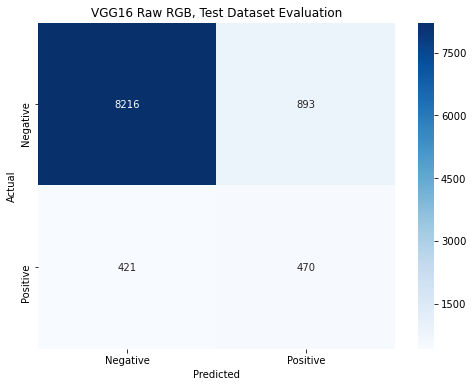

In [9]:
c_labels = [int(x) for x in labels]
predictions = model.predict_classes(features, batch_size=None)
pred = [x[0] for x in list(predictions)]
mat = tf.math.confusion_matrix(c_labels, pred)
df = pd.DataFrame(mat.numpy(), columns=['AP','AN'], index=['PP','PN'])
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(df, cmap="Blues", annot=True, fmt="d", xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
ax.set_ylim([2,0])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('VGG16 Raw RGB, Test Dataset Evaluation')
plt.show()

In [18]:
mat

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[2841,   99],
       [  75, 2854]])>

In [15]:
pred.count(0)

9828

In [9]:
cv.imshow('aa',features[0])

In [10]:
cv.destroyAllWindows()

In [27]:
for img, pred in zip(features, predictions):
    if pred > 0.5:
        while True:
            cv.imshow('aa',img)
            k = cv.waitKey(0)
            if k == 27:         # wait for ESC key to exit
                break
    cv.destroyAllWindows()

KeyboardInterrupt: 

In [28]:
cv.destroyAllWindows()

In [24]:
predictions = model.predict(features, batch_size=None)


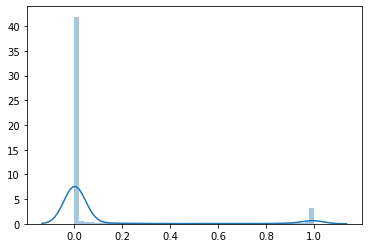

In [ ]:
pred = [x[0] for x in list(predictions)]